In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import os 
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, Dataset
from matplotlib import pyplot as plt
from jiwer import cer 

**credits**: The following code is heavily inspired by 
- https://github.com/cmudeeplearning11785/Fall2018-tutorials/blob/master/recitation-8/ctc_handwritten_digit_reader.ipynb
- https://github.com/pythonlessons/mltu/blob/main/Tutorials/08_handwriting_recognition_torch/model.py

### generate and load data

In [2]:
def load_data():
    path = "data/iam_dataset/"
    imgs = np.load(path + "iam_images.npy") 
    labels = np.load(path + "iam_labels.npy") 
    return imgs, labels
images, labels_str = load_data() 
print("images", images.shape) 
print("images", labels_str.shape)
images = 1 - images


images (10001, 100, 100)
images (10001,)


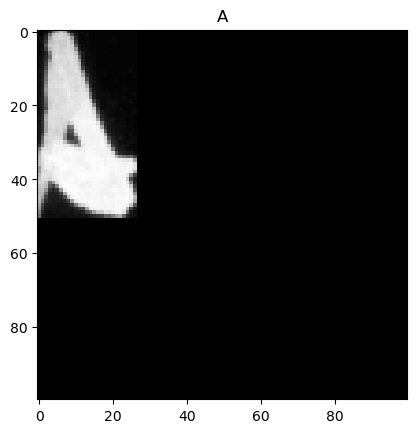

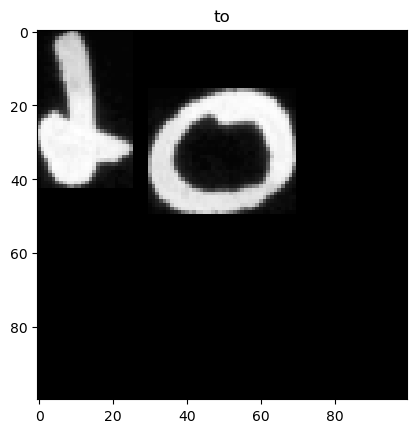

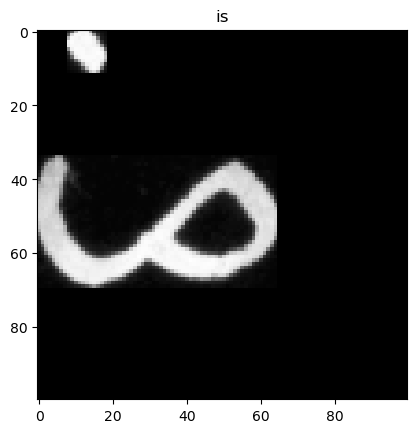

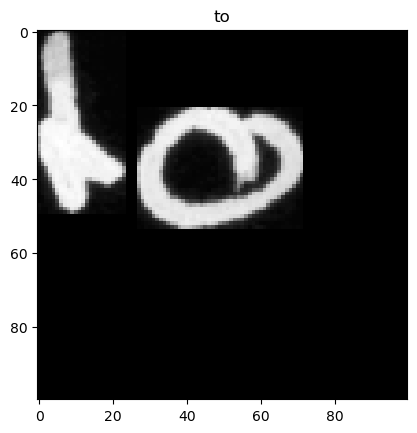

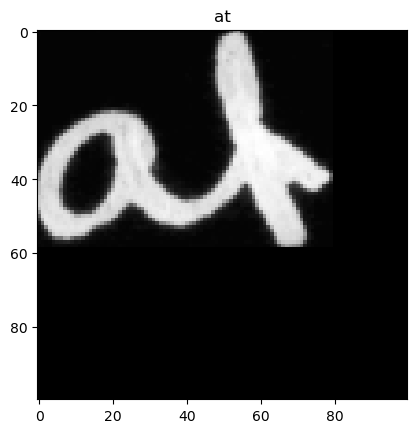

In [3]:
for i in range(5):
    plt.imshow(images[i], cmap="gray")
    plt.title(labels_str[i])
    plt.show()

### constants 

In [5]:
# train/test split
split = 0.8
batch_size = 32
max_epochs = 1000
device = "mps" if torch.backends.mps.is_available() else "cpu"
#device = "cpu" 

### data preprocessing

In [6]:

chars = list(set([c for l in labels_str for c in l])) 
chars.sort()
print("chars=", chars)
char2idx = {c:i for i, c in enumerate(chars)} 
idx2char = {i:c for i, c in enumerate(chars)}
labels = [[char2idx[c] for c in l] for l in labels_str] 
print("labels=", labels_str[:5])
print("labels=", labels[:5])
print("labels to str=", ["".join([idx2char[i] for i in l]) for l in labels[:5]]) 
blank = len(chars)



chars= ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
labels= ['A' 'to' 'is' 'to' 'at']
labels= [[24], [67, 62], [56, 66], [67, 62], [48, 67]]
labels to str= ['A', 'to', 'is', 'to', 'at']


In [7]:

class IAMDataset(Dataset):
    def __init__(self, images, labels): 
        self.images = images 
        self.labels = labels
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label


def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]
    lengths = [len(label) for label in labels]
    flattened_labels = [c for label in labels for c in label]
    return images, torch.tensor(flattened_labels), torch.tensor(lengths)


split_idx = int(len(images) * split) 

train_set = IAMDataset(
    torch.tensor(images[:split_idx], dtype=torch.float32), 
    labels[:split_idx]
)
test_set = IAMDataset(
    torch.tensor(images[split_idx:], dtype=torch.float32), 
    labels[split_idx:]
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

print("train_set", len(train_set))
print("test_set", len(test_set))

train_set 8000
test_set 2001


### model architecture

In [8]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__() 
        self.embed = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=(2, 1), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=(2, 2), padding=(1, 1), bias=False),
            nn.ELU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=(1, 1), padding=(1, 1), bias=False),
            nn.ELU()
        )
        dim = 800
        hidden_size = 256
        self.lstm = nn.LSTM(input_size=dim, hidden_size=hidden_size)
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=len(chars)+1)

    def forward(self, features):
        # features: n, 1, h, w
        embedding = self.embed(features)
        n, c, h, w = embedding.size() 
        embedding = embedding.view(n, c*h, w).permute(2, 0, 1)
        # embed: t, n, f
        h, _ = self.lstm(embedding)
        logits = self.output_layer(h)
        
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)
        return log_probs    

### decoding and error function

In [13]:
def greedy_decode(log_probs, blank_index):
    """
    Decode using greedy method.
    :param log_probs: Log probabilities from the model (T x V)
    :param blank_index: Index of the blank token
    :return: Decoded sequence as a string
    """
    max_indices = np.argmax(log_probs, axis=1)  # Argmax over vocabulary
    sequence = ""
    previous = None
    for index in max_indices:
        if index != previous:  # Skip consecutive duplicates
            if index != blank_index:  # Skip blank tokens
                sequence += idx2char[index]
        previous = index

    return sequence

def caracter_error_rate(model,dataset):
    model.eval()
    avg_cer = 0
    model = model.to("cpu")
    for image,label in dataset: 
        predicted = model(image.unsqueeze(0).unsqueeze(0)).detach().cpu() # (1, 1, h, w)
        label = "".join([idx2char[i] for i in label])
        predicted_text = greedy_decode(predicted.squeeze().numpy(), blank)
        curr_cer = cer(label, predicted_text) if len(predicted_text) > 0 else 1
        avg_cer += curr_cer  
    
    avg_cer /= len(dataset) 
    model.train()
    model.to(device)
    return avg_cer

### model training

In [14]:
model = CNNLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CTCLoss(blank=blank) 
 

In [15]:
for i in range(max_epochs): 
    
    mean_loss = 0 
    for image, label, target_lengths in train_loader:
        # move to device
        image = image.to(device)
        label = label.to(device)
        target_lengths = target_lengths.to(device).long()
        image = image.unsqueeze(1) # (b, 1, h, w) 

        
        # start training 
        optimizer.zero_grad()
        log_probs = model(image)
        input_lengths = torch.full((image.shape[0],), log_probs.shape[0], dtype=torch.long)    
       
       
        loss = criterion(log_probs, label, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        
        mean_loss += loss.item()
    
    print(f"epoch:", i, "loss(train):", mean_loss/len(train_loader))# "cer(test):", _cer)
    if i % 10 == 0:
        print("cer(test):", caracter_error_rate(model, test_set))
    
    

epoch: 0 loss(train): 8.203115674972533
cer(test): 0.7203481592537069
epoch: 1 loss(train): 2.616271599292755
epoch: 2 loss(train): 2.465076660633087
epoch: 3 loss(train): 2.3867406649589538
epoch: 4 loss(train): 2.3273072090148927
epoch: 5 loss(train): 2.273185577869415
epoch: 6 loss(train): 2.2317510657310486
epoch: 7 loss(train): 2.1915659656524658
epoch: 8 loss(train): 2.1636487789154053
epoch: 9 loss(train): 2.136430290699005
epoch: 10 loss(train): 2.10448992061615
cer(test): 0.6410211560886226
epoch: 11 loss(train): 2.076196231365204
epoch: 12 loss(train): 2.0516427574157716
epoch: 13 loss(train): 2.017839427471161
epoch: 14 loss(train): 2.0004365186691286
epoch: 15 loss(train): 1.9746751527786255
epoch: 16 loss(train): 1.9459363751411438
epoch: 17 loss(train): 1.9102215538024903
epoch: 18 loss(train): 1.881719090461731
epoch: 19 loss(train): 1.8580822534561157
epoch: 20 loss(train): 1.8264368062019347
cer(test): 0.5618607362985173
epoch: 21 loss(train): 1.796015221118927
epoch: 

KeyboardInterrupt: 

In [16]:
print(f"train cer:", caracter_error_rate(model, train_set)) 
print(f"test cer:", caracter_error_rate(model, test_set)) 

train cer: 0.19025853174603102
test cer: 0.46644177911044465


label [62, 65]
label ['o', 'r']
argmax shape torch.Size([50, 1])
argmax tensor([48])
Predicted text before decoding: ['a', 'r']
Predicted text: ar
True text: or
CER: 0.5


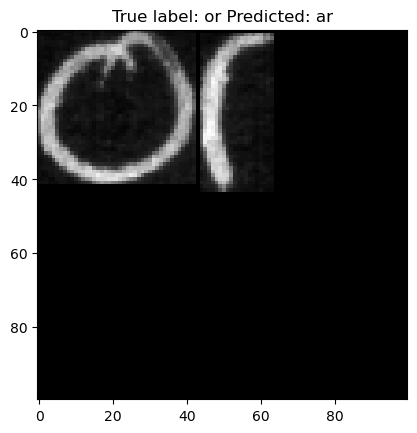

label [67, 55, 52]
label ['t', 'h', 'e']
argmax shape torch.Size([50, 1])
argmax tensor([67])
Predicted text before decoding: ['t', 'h', 'e']
Predicted text: the
True text: the
CER: 0.0


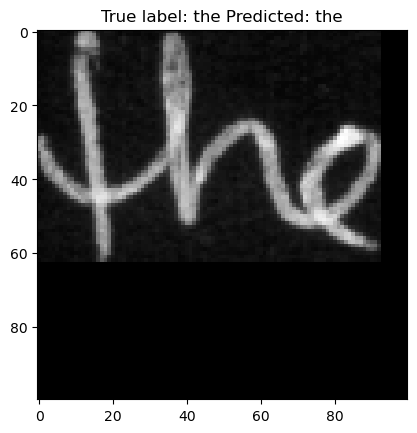

label [56, 53]
label ['i', 'f']
argmax shape torch.Size([50, 1])
argmax tensor([56])
Predicted text before decoding: ['i', 't', 't']
Predicted text: it
True text: if
CER: 0.5


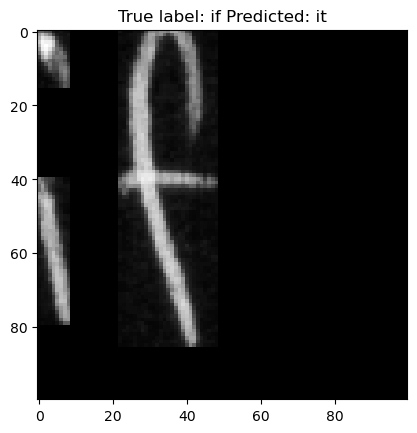

label [70, 52]
label ['w', 'e']
argmax shape torch.Size([50, 1])
argmax tensor([48])
Predicted text before decoding: ['a', 'e', 't']
Predicted text: aet
True text: we
CER: 1.0


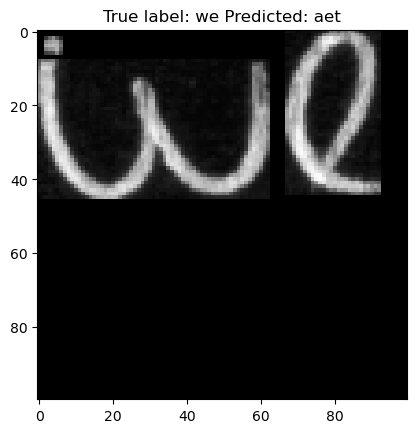

label [48]
label ['a']
argmax shape torch.Size([50, 1])
argmax tensor([48])
Predicted text before decoding: ['a']
Predicted text: a
True text: a
CER: 0.0


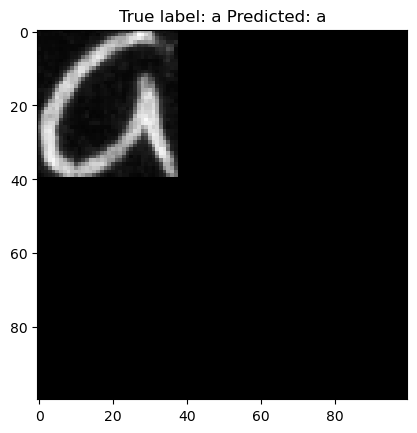

label [56, 61]
label ['i', 'n']
argmax shape torch.Size([50, 1])
argmax tensor([56])
Predicted text before decoding: ['i', 'n', 'n']
Predicted text: in
True text: in
CER: 0.0


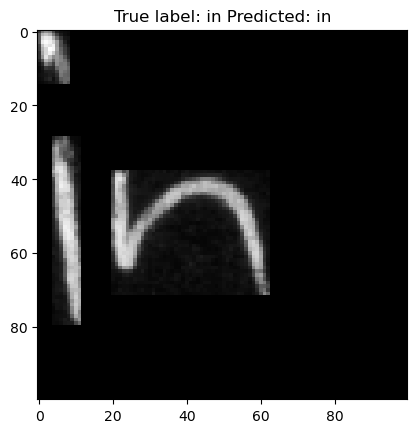

label [67, 55, 52]
label ['t', 'h', 'e']
argmax shape torch.Size([50, 1])
argmax tensor([67])
Predicted text before decoding: ['t', 'h', 'e', 'e']
Predicted text: the
True text: the
CER: 0.0


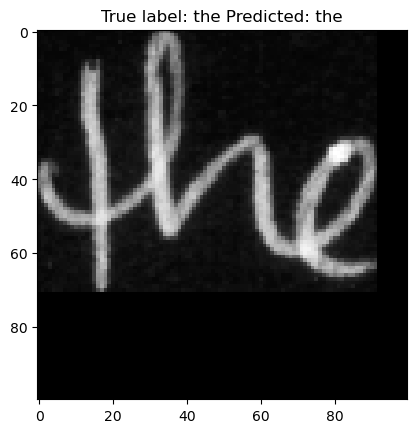

label [56, 61]
label ['i', 'n']
argmax shape torch.Size([50, 1])
argmax tensor([56])
Predicted text before decoding: ['i', 'n', 'n']
Predicted text: in
True text: in
CER: 0.0


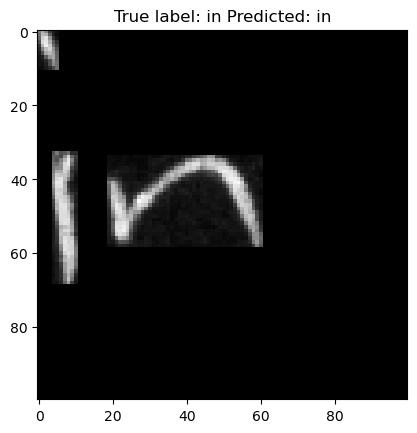

label [55, 56, 66]
label ['h', 'i', 's']
argmax shape torch.Size([50, 1])
argmax tensor([55])
Predicted text before decoding: ['h']
Predicted text: h
True text: his
CER: 0.6666666666666666


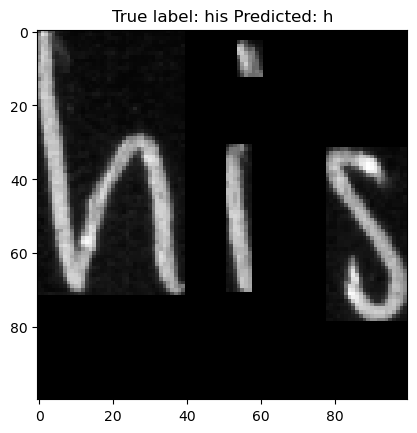

label [9]
label ['.']
argmax shape torch.Size([50, 1])
argmax tensor([9])
Predicted text before decoding: ['.']
Predicted text: .
True text: .
CER: 0.0


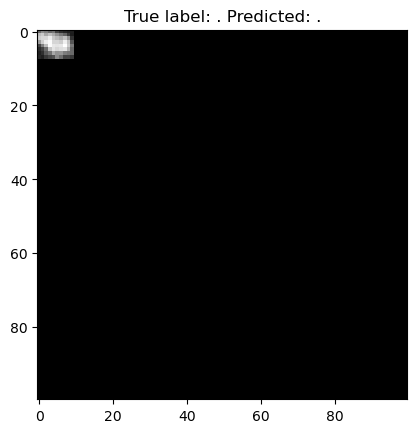

label [32, 67]
label ['I', 't']
argmax shape torch.Size([50, 1])
argmax tensor([67])
Predicted text before decoding: ['t', 't']
Predicted text: tt
True text: It
CER: 0.5


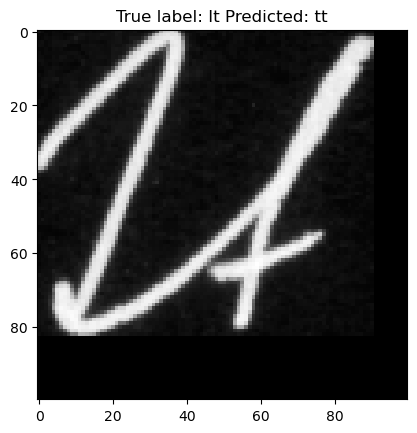

label [7]
label [',']
argmax shape torch.Size([50, 1])
argmax tensor([7])
Predicted text before decoding: [',']
Predicted text: ,
True text: ,
CER: 0.0


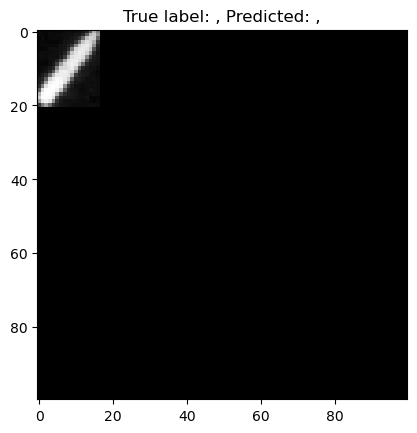

label [7]
label [',']
argmax shape torch.Size([50, 1])
argmax tensor([7])
Predicted text before decoding: [',']
Predicted text: ,
True text: ,
CER: 0.0


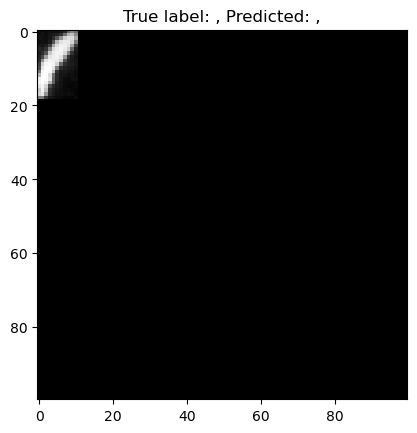

label [62, 53]
label ['o', 'f']
argmax shape torch.Size([50, 1])
argmax tensor([62])
Predicted text before decoding: ['o', 'f', 'f', 'f']
Predicted text: of
True text: of
CER: 0.0


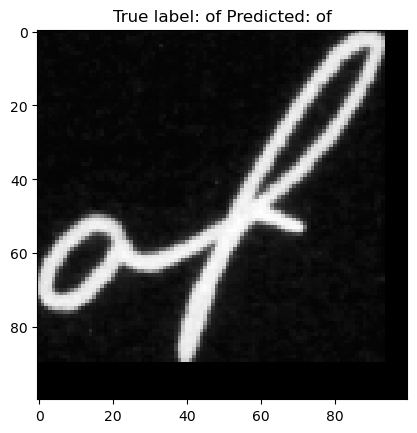

label [67, 62]
label ['t', 'o']
argmax shape torch.Size([50, 1])
argmax tensor([67])
Predicted text before decoding: ['t', 'o', 'o']
Predicted text: to
True text: to
CER: 0.0


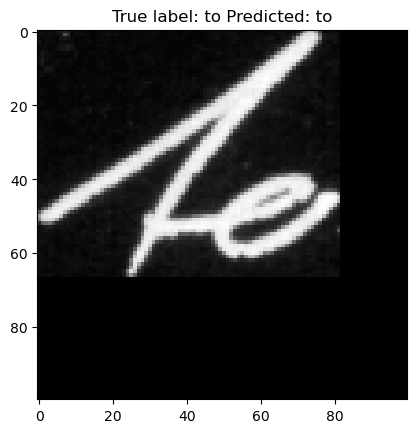

label [48]
label ['a']
argmax shape torch.Size([50, 1])
argmax tensor([48])
Predicted text before decoding: ['a']
Predicted text: a
True text: a
CER: 0.0


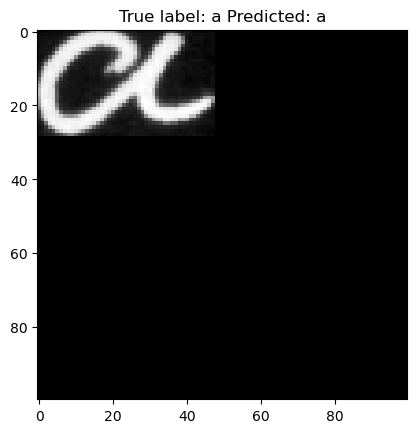

label [56, 67, 66]
label ['i', 't', 's']
argmax shape torch.Size([50, 1])
argmax tensor([67])
Predicted text before decoding: ['t', 'o']
Predicted text: to
True text: its
CER: 0.6666666666666666


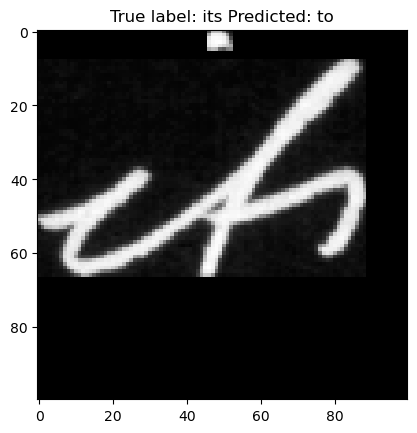

label [56, 61]
label ['i', 'n']
argmax shape torch.Size([50, 1])
argmax tensor([56])
Predicted text before decoding: ['i', 's', 's']
Predicted text: is
True text: in
CER: 0.5


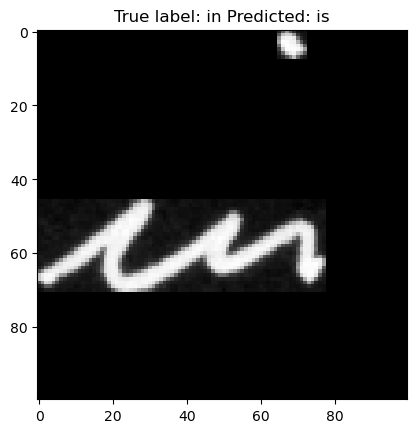

label [7]
label [',']
argmax shape torch.Size([50, 1])
argmax tensor([1])
Predicted text before decoding: ['"']
Predicted text: "
True text: ,
CER: 1.0


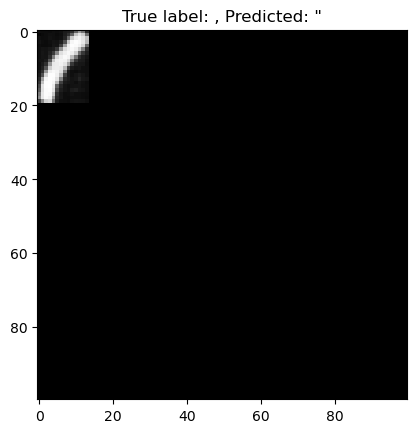

label [9]
label ['.']
argmax shape torch.Size([50, 1])
argmax tensor([9])
Predicted text before decoding: ['.']
Predicted text: .
True text: .
CER: 0.0


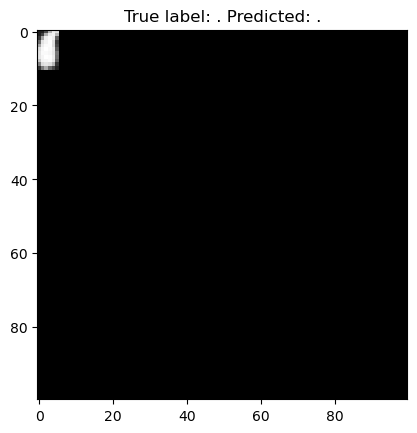

In [19]:
model = model.to("cpu") 
for i in range(20): 
    image, label = test_set[i]
    
    print("label", label)
    print("label", [idx2char[i] for i in label])
    label_str = "".join([idx2char[i] for i in label ])  
    
    
    plt.imshow(image.squeeze(), cmap="gray")

    
    predicted = model(image.unsqueeze(0).unsqueeze(0)).detach().cpu() # (1, 1, h, w)
    # print("predicted", predicted)
    predicted_text = greedy_decode(predicted.squeeze().numpy(), blank)
    
    arg_max = np.argmax(predicted, axis=2) 
    print("argmax shape", arg_max.shape)
    print("argmax", arg_max[0]) 
    pred_to_chars = [idx2char[int(i)] for i in arg_max if int(i) != blank]
     
    print("Predicted text before decoding:", pred_to_chars) 
    
    print("Predicted text:", predicted_text)
    print("True text:", label_str)
    print("CER:", cer(label_str, predicted_text))
    plt.title("True label: " + label_str + " Predicted: " + predicted_text)
    plt.show()
    